# Import Libary

In [1]:
import os
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from wordcloud import WordCloud, STOPWORDS
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text
import kagglehub


# Loading Data from kaggle

In [2]:
src_path = kagglehub.dataset_download("shivamb/netflix-shows")
print("Downloaded to:", src_path)

dst_path = "E:/Data Project/Netflix Content Insight"

os.makedirs(dst_path, exist_ok=True)

for filename in os.listdir(src_path):
    full_src = os.path.join(src_path, filename)
    full_dst = os.path.join(dst_path, filename)
    shutil.move(full_src, full_dst)

print("Moved to:", dst_path)

Downloaded to: C:\Users\pakaw\.cache\kagglehub\datasets\shivamb\netflix-shows\versions\5
Moved to: E:/Data Project/Netflix Content Insight


# EDA

In [3]:
# ระบุ path ไปยังไฟล์ .csv
csv_path = "E:/Data Project/Netflix Content Insight/netflix_titles.csv"

# อ่านไฟล์ CSV
df = pd.read_csv(csv_path)

# แสดงข้อมูล 5 แถวแรก
print(df.head())

  show_id     type                  title         director  \
0      s1    Movie   Dick Johnson Is Dead  Kirsten Johnson   
1      s2  TV Show          Blood & Water              NaN   
2      s3  TV Show              Ganglands  Julien Leclercq   
3      s4  TV Show  Jailbirds New Orleans              NaN   
4      s5  TV Show           Kota Factory              NaN   

                                                cast        country  \
0                                                NaN  United States   
1  Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...   South Africa   
2  Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...            NaN   
3                                                NaN            NaN   
4  Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...          India   

           date_added  release_year rating   duration  \
0  September 25, 2021          2020  PG-13     90 min   
1  September 24, 2021          2021  TV-MA  2 Seasons   
2  September 24, 2021        

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB


In [5]:
df.isnull().sum().sort_values(ascending=False)

director        2634
country          831
cast             825
date_added        10
rating             4
duration           3
show_id            0
type               0
title              0
release_year       0
listed_in          0
description        0
dtype: int64

# Cleaning Datta

In [6]:
df['director'] = df['director'].fillna('Unknown')
df['cast'] = df['cast'].fillna('Unknown')
df['country'] = df['country'].fillna('Unknown')


In [7]:
df = df.dropna(subset=['date_added'])

In [8]:
df['date_added'] = df['date_added'].str.strip()  # cleaqr spaces
df['date_added'] = pd.to_datetime(df['date_added'], format='%B %d, %Y', errors='coerce')



df['date_added'] = pd.to_datetime(df['date_added'])

In [9]:
df = df.drop_duplicates()

In [10]:
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
Index: 8797 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   show_id       8797 non-null   object        
 1   type          8797 non-null   object        
 2   title         8797 non-null   object        
 3   director      8797 non-null   object        
 4   cast          8797 non-null   object        
 5   country       8797 non-null   object        
 6   date_added    8797 non-null   datetime64[ns]
 7   release_year  8797 non-null   int64         
 8   rating        8793 non-null   object        
 9   duration      8794 non-null   object        
 10  listed_in     8797 non-null   object        
 11  description   8797 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(10)
memory usage: 893.4+ KB


show_id         0
type            0
title           0
director        0
cast            0
country         0
date_added      0
release_year    0
rating          4
duration        3
listed_in       0
description     0
dtype: int64

In [11]:
df['type'].value_counts()

type
Movie      6131
TV Show    2666
Name: count, dtype: int64

In [12]:
df['year_added'] = df['date_added'].dt.year
df['month_added'] = df['date_added'].dt.month


# Analyze and Visuallize

### Poportion of content in Netflix

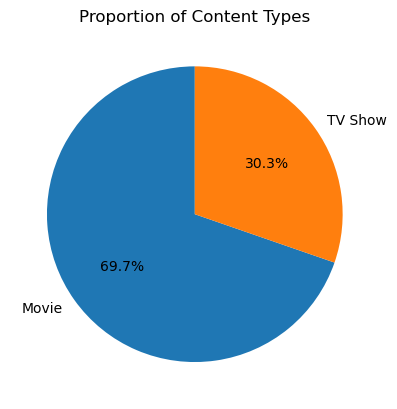

In [13]:
df['type'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90, title='Proportion of Content Types')
plt.ylabel('')
plt.show()

### Item added each years

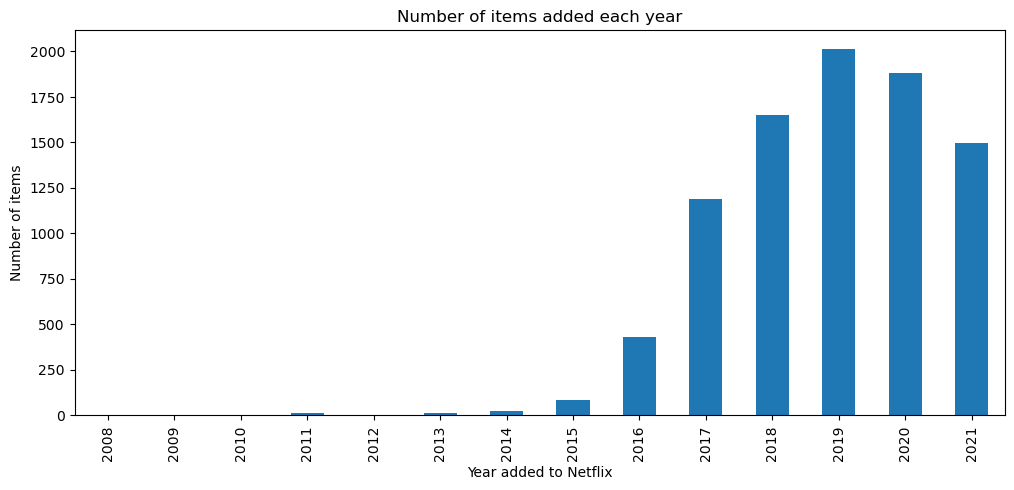

In [14]:
df['year_added'].value_counts().sort_index().plot(kind='bar', figsize=(12,5), title='Number of items added each year')
plt.xlabel('Year added to Netflix')
plt.ylabel('Number of items')
plt.show()

### Top 10 Countries with Content on Netflix

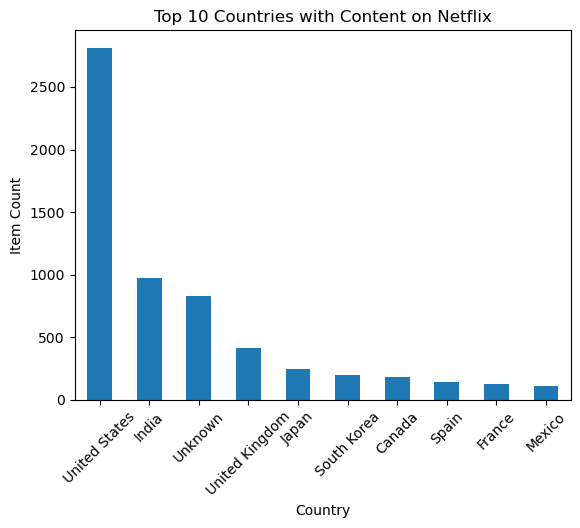

In [15]:
df['country'].value_counts().head(10).plot(kind='bar', title='Top 10 Countries with Content on Netflix')
plt.xlabel('Country')
plt.ylabel('Item Count')
plt.xticks(rotation=45)
plt.show()


### Most common list length

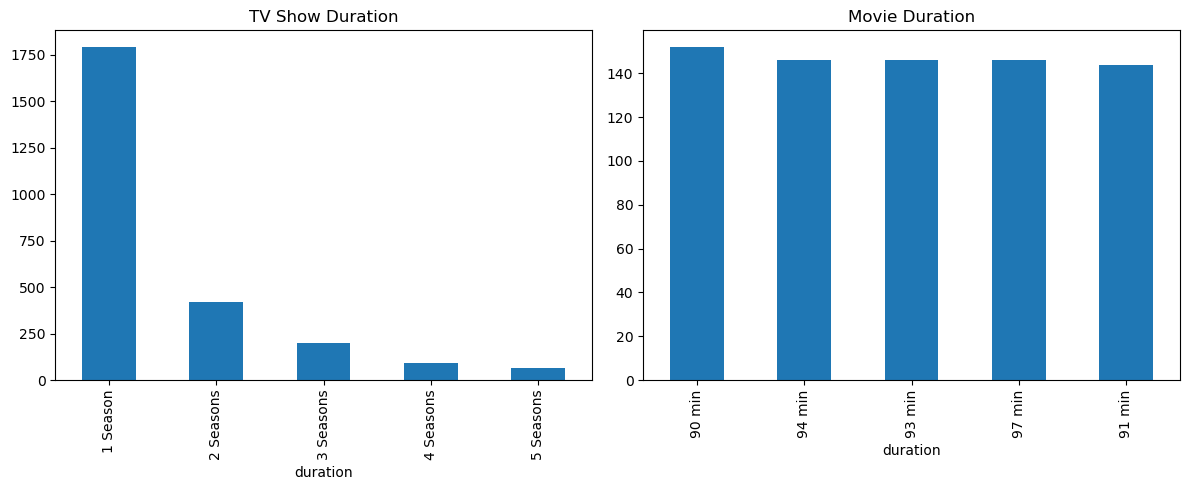

In [16]:
# แยกประเภท
tv = df[df['type'] == 'TV Show']
movie = df[df['type'] == 'Movie']

# นับค่าซ้ำ
tv_duration = tv['duration'].value_counts().head(5)
movie_duration = movie['duration'].value_counts().head(5)

# วาดกราฟเปรียบเทียบ
fig, ax = plt.subplots(1, 2, figsize=(12,5))
tv_duration.plot(kind='bar', ax=ax[0], title='TV Show Duration')
movie_duration.plot(kind='bar', ax=ax[1], title='Movie Duration')
plt.tight_layout()
plt.show()


## Content in Thailand

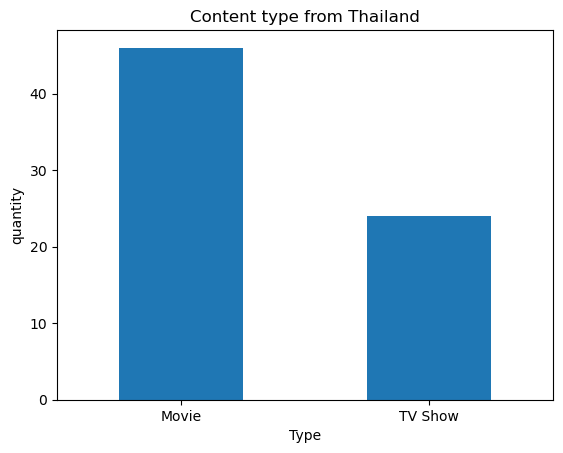

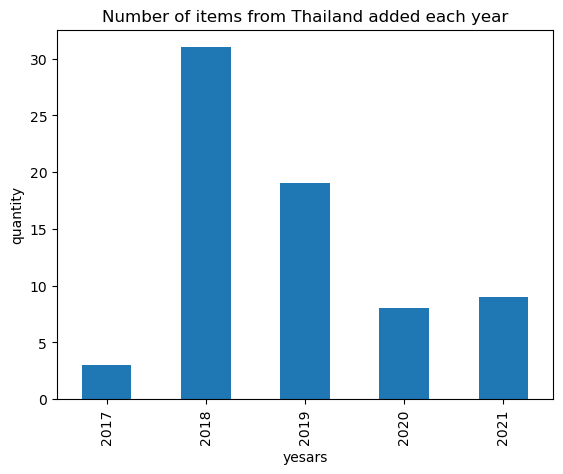

In [17]:
# เลือกรายการที่มีคำว่า "Thailand" ในคอลัมน์ country
df_thailand = df[df['country'].str.contains("Thailand", na=False)]

# จำนวน Movie vs TV Show
df_thailand['type'].value_counts().plot(kind='bar', title='Content type from Thailand')
plt.xlabel('Type')
plt.ylabel('quantity')
plt.xticks(rotation=0)
plt.show()

# รายการไทยเพิ่มเข้า Netflix ในแต่ละปี
df_thailand['year_added'].value_counts().sort_index().plot(kind='bar', title='Number of items from Thailand added each year')
plt.xlabel('yesars')
plt.ylabel('quantity')
plt.show()


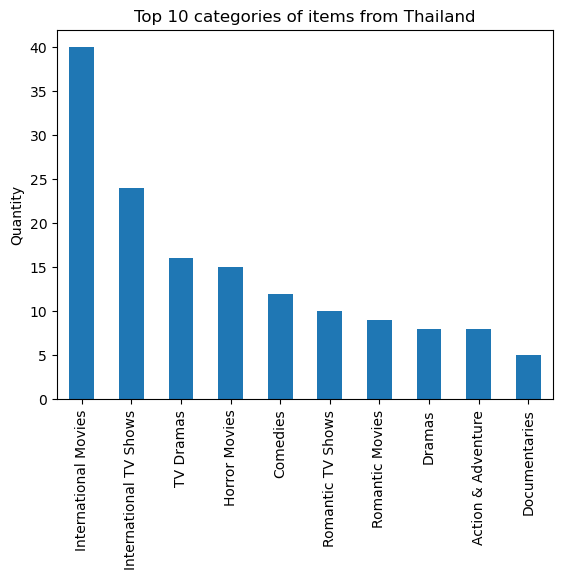

In [18]:
genres_th = df_thailand['listed_in'].dropna().apply(lambda x: [i.strip() for i in x.split(',')])
flat_genres_th = [g for sublist in genres_th for g in sublist]
pd.Series(Counter(flat_genres_th)).sort_values(ascending=False).head(10).plot(kind='bar', title='Top 10 categories of items from Thailand')
plt.xticks(rotation=90)
plt.ylabel('Quantity')
plt.show()

## Rating

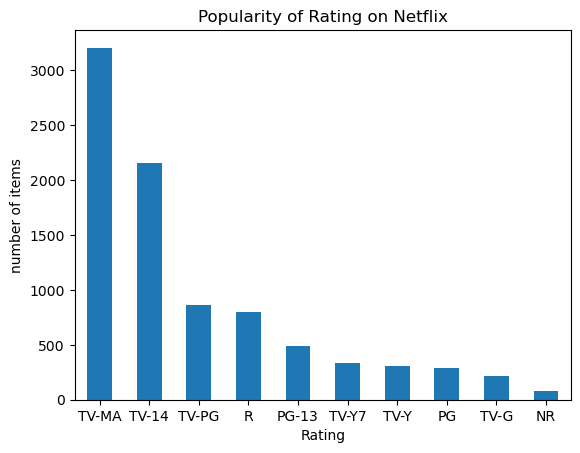

In [19]:

df['rating'].value_counts().head(10).plot(kind='bar', title='Popularity of Rating on Netflix')
plt.xlabel('Rating')
plt.ylabel('number of items')
plt.xticks(rotation=0)
plt.show()


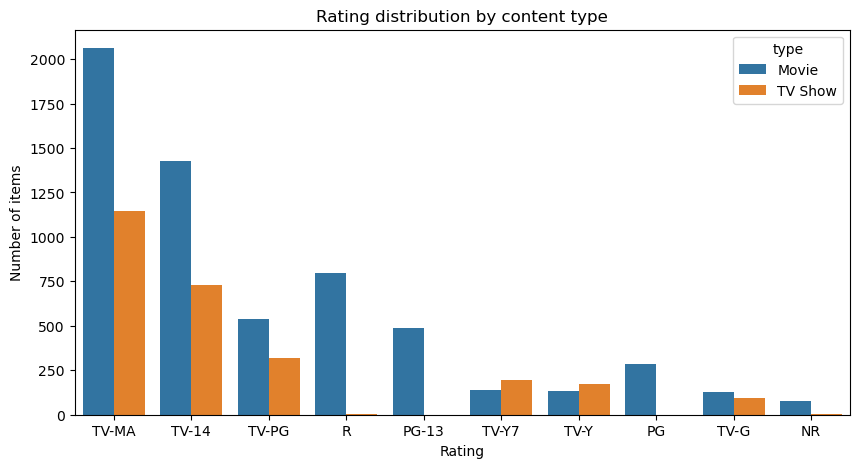

In [20]:
df_rating = df[['type', 'rating']].dropna()

plt.figure(figsize=(10, 5))
sns.countplot(data=df_rating, x='rating', hue='type', order=df_rating['rating'].value_counts().index[:10])
plt.title('Rating distribution by content type')
plt.xlabel('Rating')
plt.ylabel('Number of items')
plt.xticks(rotation=0)
plt.show()


## growth

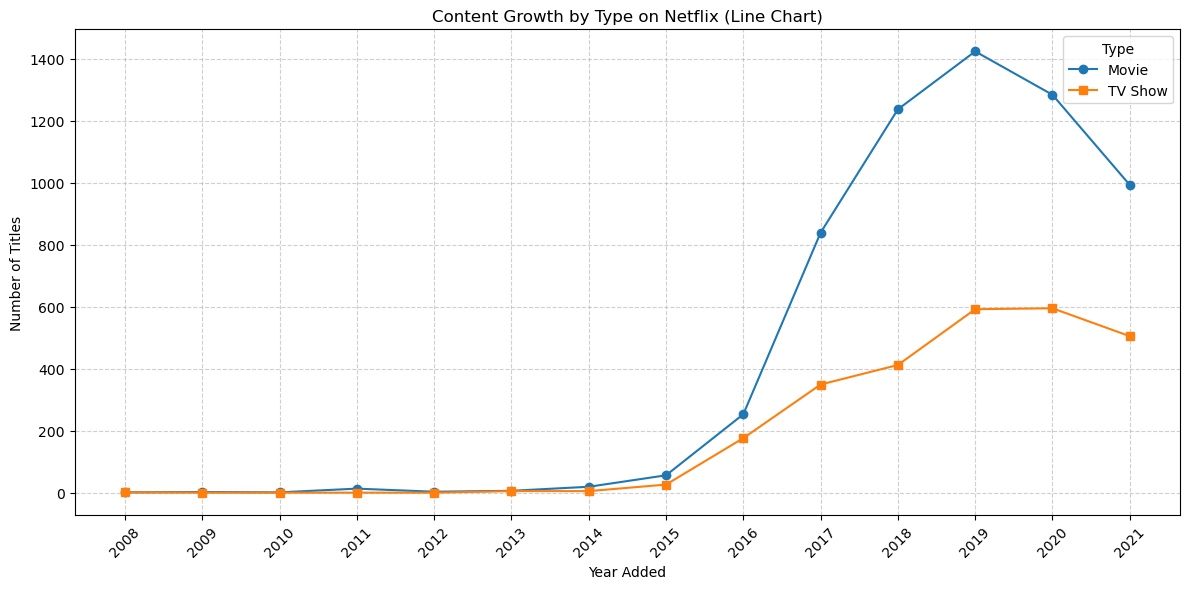

In [21]:
growth = df.groupby(['year_added', 'type']).size().unstack(fill_value=0)

plt.figure(figsize=(12, 6))
plt.plot(growth.index, growth['Movie'], label='Movie', marker='o')
plt.plot(growth.index, growth['TV Show'], label='TV Show', marker='s')

plt.title('Content Growth by Type on Netflix (Line Chart)')
plt.xlabel('Year Added')
plt.ylabel('Number of Titles')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Type')
plt.xticks(growth.index, rotation=45)
plt.tight_layout()
plt.show()

## Compare Top 10 Genres Between types

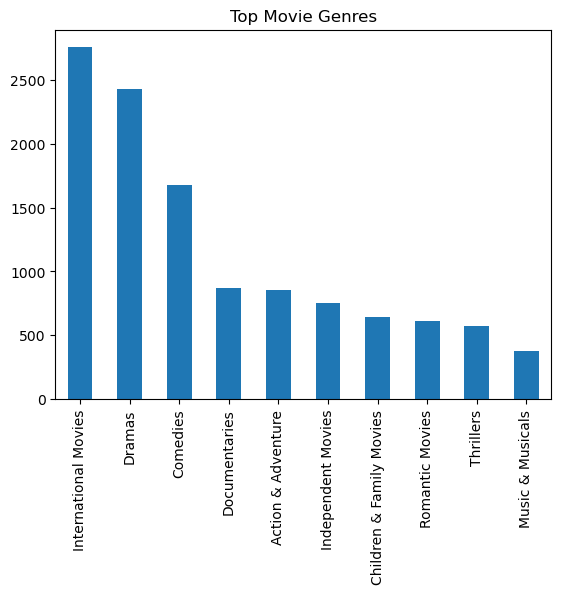

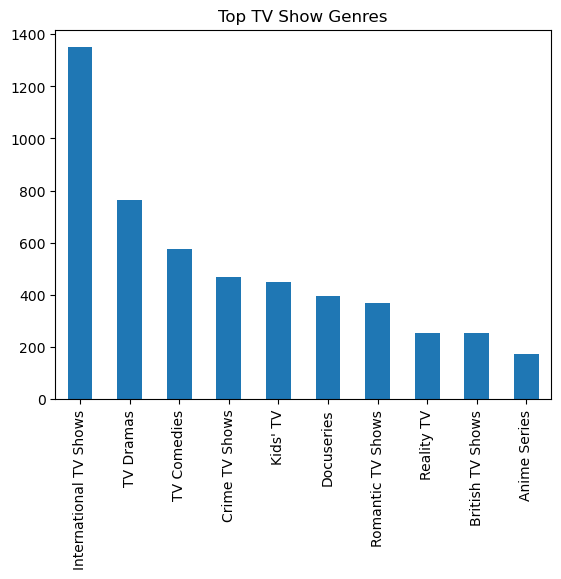

In [22]:
movie_df = df[df['type'] == 'Movie']
tv_df = df[df['type'] == 'TV Show']


movie_genres = movie_df['listed_in'].dropna().apply(lambda x: [i.strip() for i in x.split(',')])
tv_genres = tv_df['listed_in'].dropna().apply(lambda x: [i.strip() for i in x.split(',')])

movie_flat = [g for sub in movie_genres for g in sub]
tv_flat = [g for sub in tv_genres for g in sub]


pd.Series(Counter(movie_flat)).sort_values(ascending=False).head(10).plot(kind='bar', title='Top Movie Genres')
plt.show()

pd.Series(Counter(tv_flat)).sort_values(ascending=False).head(10).plot(kind='bar', title='Top TV Show Genres')
plt.show()


## Duration Distribution of Movies and TV Shows

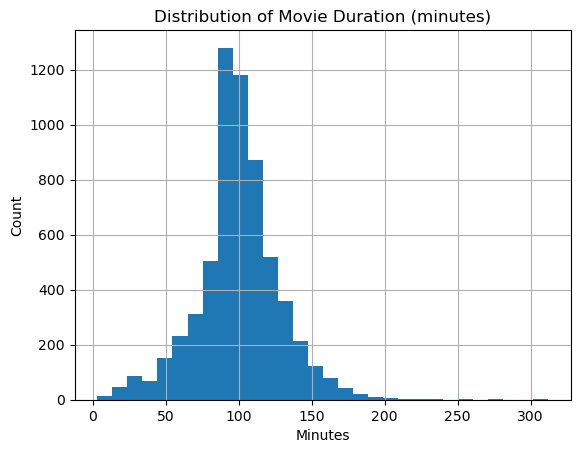

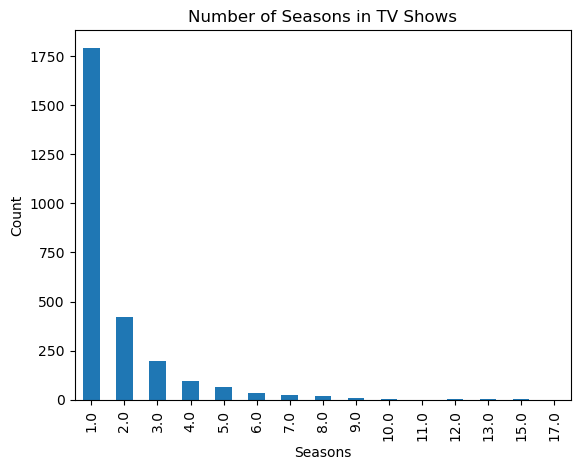

In [23]:

movie_df = df[df['type'] == 'Movie'].copy()
tv_df = df[df['type'] == 'TV Show'].copy()

# ดึงตัวเลขจาก duration (แบบปลอดภัย)
movie_df['duration_minutes'] = movie_df['duration'].str.extract(r'(\d+)').astype(float)
tv_df['seasons'] = tv_df['duration'].str.extract(r'(\d+)').astype(float)

# Plot
movie_df['duration_minutes'].hist(bins=30)
plt.title('Distribution of Movie Duration (minutes)')
plt.xlabel('Minutes')
plt.ylabel('Count')
plt.show()

tv_df['seasons'].value_counts().sort_index().plot(kind='bar')
plt.title('Number of Seasons in TV Shows')
plt.xlabel('Seasons')
plt.ylabel('Count')
plt.show()


## Netflix Origin

In [24]:
df['is_netflix_original'] = df['title'].str.contains("Netflix", case=False, na=False)
df_original = df[df['is_netflix_original']].copy()

df_original[['title', 'type', 'country', 'rating', 'date_added']].sort_values('date_added', ascending=False).head(10)

,title,type,country,rating,date_added
8437,The Netflix Afterparty,TV Show,United States,TV-MA,2021-01-02
1553,The Netflix Afterparty: The Best Shows of The ...,Movie,United States,TV-MA,2020-12-13
5493,Handsome: A Netflix Mystery Movie,Movie,United States,TV-MA,2017-05-05
5862,Netflix Presents: The Characters,TV Show,United States,TV-MA,2016-03-11


## Keyword analysis

In [25]:

# ลบ missing ใน description
df_desc = df.dropna(subset=['description']).copy()

# ใช้เฉพาะ description
corpus = df_desc['description'].astype(str).values


In [26]:
# ✅ รวม stop words ภาษาอังกฤษ + คำที่เราต้องการลบเอง
default_stopwords = text.ENGLISH_STOP_WORDS
custom_words = ['netflix', 'series', 'story', 'show', 'film', 'films', 'tv', 'movie','and']
custom_stopwords = list(default_stopwords.union(custom_words))  # 💡 แปลงเป็น list

# ✅ ตั้งค่า TF-IDF โดยใส่ stop words แบบ list
tfidf = TfidfVectorizer(stop_words=custom_stopwords, max_features=1000)

# ✅ ใช้ description ในการวิเคราะห์
corpus = df['description'].dropna().astype(str).values
X_tfidf = tfidf.fit_transform(corpus)

# ✅ ดึง top 20 คำสำคัญ
tfidf_scores = np.asarray(X_tfidf.mean(axis=0)).ravel()
top_n = 20
top_indices = tfidf_scores.argsort()[::-1][:top_n]
feature_names = np.array(tfidf.get_feature_names_out())
top_keywords = list(zip(feature_names[top_indices], tfidf_scores[top_indices]))

# ✅ แสดงผลลัพธ์
for word, score in top_keywords:
    print(f"{word}: {score:.4f}")


life: 0.0219
young: 0.0194
new: 0.0190
family: 0.0177
world: 0.0168
man: 0.0157
love: 0.0149
woman: 0.0145
friends: 0.0140
documentary: 0.0129
school: 0.0109
finds: 0.0104
father: 0.0102
home: 0.0101
old: 0.0099
lives: 0.0097
help: 0.0097
high: 0.0096
takes: 0.0094
group: 0.0093


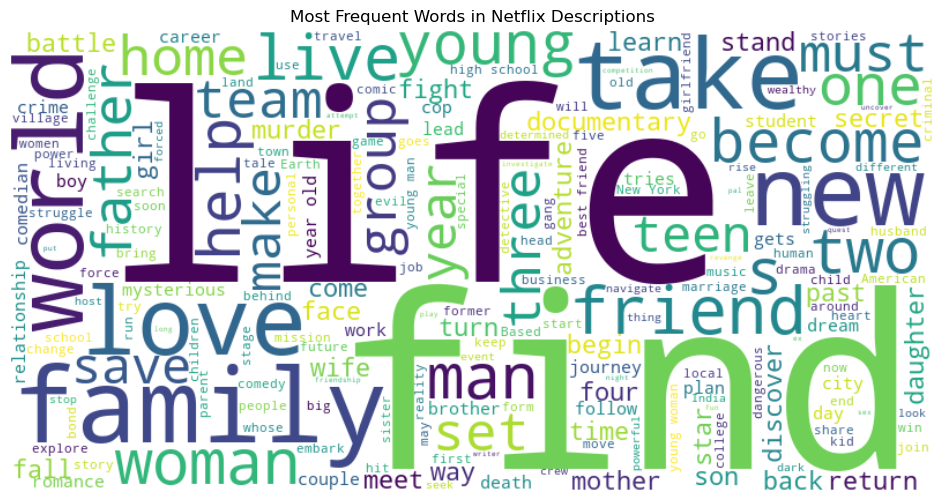

In [27]:
# รวมคำทั้งหมดจาก description
text_all = " ".join(corpus)

# ใช้ stopwords ของ WordCloud และเพิ่มคำเองได้
custom_stopwords = set(STOPWORDS)
custom_stopwords.update(['netflix', 'series', 'show', 'movie', 'films', 'film', 'tv'])

# สร้าง WordCloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    stopwords=custom_stopwords
).generate(text_all)

# แสดงผล
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Most Frequent Words in Netflix Descriptions")
plt.show()
